# Phase 1, Phase 2 tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_VISIBLE_DEVICES"] = "0"

In [3]:
import jax
import hlax
import tomli
import optax
import distrax
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from functools import partial
from itertools import product
from flax.core import freeze, unfreeze
from flax.training.train_state import TrainState

In [4]:
%config InlineBackend.figure_format = "retina"

## Models

In [1082]:
from typing import Callable

class Decoder(nn.Module):
    """
    For the generative model
    p(x,z) = p(x|z) * p(z)
    """
    dim_full: int
    dim_latent: int = 20
    
    def setup(self):
        self.logit = nn.Dense(self.dim_full, use_bias=False, name="mean")
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(300)(z)
        x = nn.elu(x)
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(100)(x)
        x = nn.elu(x)
        logit_x = self.logit(x)
        return logit_x


class Encoder(nn.Module):
    """
    two-layered encoder
    """
    dim_latent: int
    n_hidden: int = 500
    normal_init: Callable = nn.initializers.normal()
    
    def setup(self):
        ...
        # self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.elu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.elu(z)
        mean_z = nn.Dense(self.dim_latent, name="mean")(z)
        logvar_z = nn.Dense(self.dim_latent, use_bias=True, name="logvar_diag")(z)
        return mean_z, logvar_z
    
    
class GaussEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.mu = self.param("mu", self.normal_init, (self.dim_latent,))
        # self.mu = nn.Dense(self.dim_latent)
        self.logvar_diag = self.param("logvar_diag", self.normal_init, (self.dim_latent,))

    def __call__(self, x):
        """
        Input x (_) is a dummy variable
        """
        # z = self.mu
        # z = self.mu(x)
        z = self.mu
        return z, self.logvar_diag

    
class UnamortisedVAEBernDelta(nn.Module):
    """
    Base class for an unamortised variational autoencoder
    with Bernoulli decoder p(x|z) = Bern(x| f(z))
    and Dirac-delta encoder q(z|x) = delta(z = z^)
    """
    latent_dim: int
    obs_dim: int
    Encoder: nn.Module
    Decoder: nn.Module

    def setup(self):
        self.encoder = nn.vmap(
            self.Encoder,
            variable_axes={"params": 0},
            split_rngs={"params": True},
            in_axes=0,
        )(self.latent_dim)
        self.decoder = self.Decoder(self.obs_dim, self.latent_dim)

    def __call__(self, x, key_eps, num_samples=1):
        z = self.encoder(x)
        logit_mean_x = self.decoder(z)
        return z, logit_mean_x


class DeltaEncoder(nn.Module):
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()

    def setup(self):
        self.z = self.param("z", self.normal_init, (self.dim_latent,))

    def __call__(self, _):
        """
        Input x (_) is a dummy variable
        """
        return self.z

## Setup

In [1189]:
batch_size = 200
key = jax.random.PRNGKey(314)
key, key_dataset = jax.random.split(key)
warmup, test = hlax.datasets.load_omniglot(key, n_train=15_000, n_test=1_000, normalize=False)
X_warmup = warmup[0].round()
X_test = test[0].round()

Files already downloaded and verified
Files already downloaded and verified


In [1190]:
dim_latent = 50
num_obs, *dim_obs = X_warmup.shape
dim_width = int(jnp.sqrt(dim_obs[0]))

## Benchmark models

In [1191]:
def elbo_bern(key, params, apply_fn, X_batch):
    """
    Importance-weighted marginal log-likelihood for
    a Bernoulli decoder and Gaussian encoder
    """
    batch_size = len(X_batch)

    encode_decode = apply_fn(params, X_batch, key)
    z, (mean_z, logvar_z), logit_mean_x = encode_decode
    _, num_is_samples, dim_latent = z.shape

    std_z = jnp.exp(logvar_z / 2)
    var_z = jnp.exp(logvar_z)
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent),
                                                jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    dist_posterior = distrax.Normal(mean_z[None, ...], std_z[None, ...])

    log_prob_z_prior = dist_prior.log_prob(z)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)
    log_prob_z_post = dist_posterior.log_prob(z).sum(axis=-1)
    
    loss = (1 + logvar_z - mean_z ** 2 - var_z).sum(axis=-1) / 2 + log_prob_x.mean(axis=0)
    return -loss.mean()



def iwae_bern_delta(key, params, apply_fn, X_batch):
    encode_decode = apply_fn(params, X_batch, key)
    z_batch, logit_mean_x = encode_decode
    _, dim_latent = z_batch.shape
    
    dist_prior = distrax.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent))
    dist_decoder = distrax.Bernoulli(logits=logit_mean_x)
    
    log_prob_z_prior = dist_prior.log_prob(z_batch)
    log_prob_x = dist_decoder.log_prob(X_batch).sum(axis=-1)

    log_prob = log_prob_z_prior + log_prob_x

    return -log_prob.mean()

## Test model

In [1192]:
model_test = hlax.models.UnamortisedVAEBern(dim_latent, dim_obs[0], GaussEncoder, Decoder)

def part_lossfn_test(params_encoder, params_decoder, key, X):
    params = freeze({
        "params": {
            "encoder": params_encoder,
            "decoder": params_decoder
        }
    })
    return elbo_bern(key, params, model_test.apply, X)

In [1193]:
model_test = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)

def part_lossfn_test(params_encoder, params_decoder, key, X):
    params = freeze({
        "params": {
            "encoder": params_encoder,
            "decoder": params_decoder
        }
    })
    return iwae_bern_delta(key, params, model_test.apply, X)

In [1194]:
def eval_unamortised(model, X, params_encoder, params_decoder):
    params = freeze({
        "params": {
            "encoder": params_encoder,
            "decoder": params_decoder
        }
    })
    return model.apply(params, X, key)

## Initialisiation

In [1195]:
key_train, key_test, key_show = jax.random.split(key, 3)
key_init_test, key_it_test = jax.random.split(key_test, 2)

n_show = 6
ixs_target = jax.random.choice(key_show, len(X_test), (n_show,))

In [1196]:
tx_test = optax.adam(1e-6)
config_test = hlax.unamortised.Config(
    num_epochs=1500,
    batch_size=200,
    num_e_steps=2
)

## Hard-EM

In [1197]:
def part_lossfn(params_encoder, params_decoder, key, X):
    params = freeze({
        "params": {
            "encoder": params_encoder,
            "decoder": params_decoder
        }
    })
    return iwae_bern_delta(key, params, model.apply, X)

In [1198]:
%%time
config = hlax.unamortised.CheckpointsConfig(
    num_epochs=500,
    batch_size=200,
    num_e_steps=5,
    eval_epochs=[],
)


model = UnamortisedVAEBernDelta(dim_latent, dim_obs[0], DeltaEncoder, Decoder)
tx_encoder = optax.adam(1e-4)
tx_decoder = optax.adam(1e-2)

output_train = hlax.unamortised.train_checkpoints(
    key_train, model, config, X_warmup, part_lossfn, tx_encoder, tx_decoder
)
# checkpoint_params = output_train["checkpoint_params"]
state_encoder, state_decoder = output_train["state_final"]
params_decoder_hem = state_decoder.params

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 1min 21s, sys: 18.6 s, total: 1min 39s
Wall time: 3min 42s


Text(0.5, 0.98, 'HardEM - Phase1')

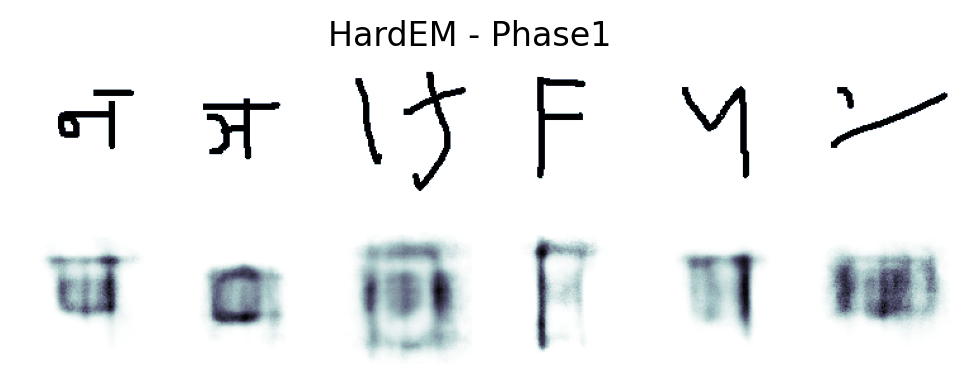

In [1199]:
_, rec = eval_unamortised(model, X_warmup, state_encoder.params, state_decoder.params)

fig, axs = plt.subplots(2, n_show, figsize=(6, 2))
for ax, ix_target in zip(axs.T, ixs_target):
    X_rec = nn.sigmoid(rec[ix_target].reshape(dim_width, dim_width))
    X_org = X_warmup[ix_target].reshape(dim_width, dim_width)

    ax[0].imshow(X_org, cmap="bone")
    ax[1].imshow(X_rec, cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
    plt.axis("off")
plt.suptitle("HardEM - Phase1")

### Test (VAE)

In [1200]:
tx_test = optax.adam(1e-5)
config_test = hlax.unamortised.Config(
    num_epochs=1000,
    batch_size=200,
    num_e_steps=3
)

In [1201]:
%%time

model_vae = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
params_test_init = model_vae.init(key_test, X_test[:2], key_test)

params_test_init = unfreeze(params_test_init)
params_test_init["params"]["decoder"] = unfreeze(params_decoder_hem)
params_test_init = freeze(params_test_init)

state_vae_test = TrainState.create(
    apply_fn=model_vae.apply,
    params=params_test_init,
    tx=tx_test,
)

output_test = hlax.amortised.train_encoder(
    key_train, config_test, X_test, state_vae_test, elbo_bern
)
hist_loss_hem_amortised = output_test[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 13.6 s, sys: 2.18 s, total: 15.8 s
Wall time: 10.2 s


Text(0.5, 0.98, 'HardEM train / VAE test - Phase2')

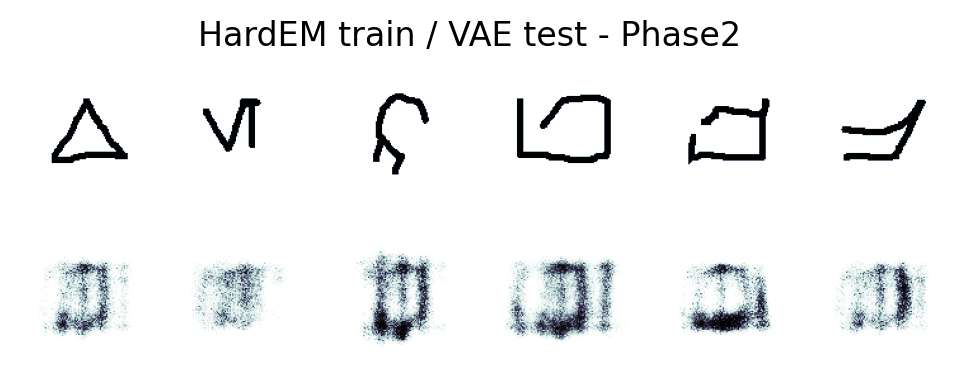

In [1202]:
fig, axs = plt.subplots(2, n_show, figsize=(6, 2))
for ax, ix_target in zip(axs.T, ixs_target):
    img_truth = X_test[ix_target].reshape(dim_width, dim_width)
    img_reconstruct = model_vae.apply(output_test[0].params, X_test[ix_target], key)[2][0].reshape(dim_width, dim_width)
    img_reconstruct = nn.sigmoid(img_reconstruct)
    
    ax[0].imshow(img_truth, cmap="bone")
    ax[1].imshow(img_reconstruct, cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.suptitle("HardEM train / VAE test - Phase2")

### Test (Unamortised diagonal FA model)

In [1203]:
tx_test_hem = optax.adam(1e-3)
res_hem_test = hlax.unamortised.train_encoder(key_it_test, model_test, config_test, X_test, state_decoder, part_lossfn_test, tx_test_hem)
params_encoder_hem_test = res_hem_test["state_final"].params
hist_loss_hem = res_hem_test["hist_loss"]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'HardEM / HardEM test - Phase2')

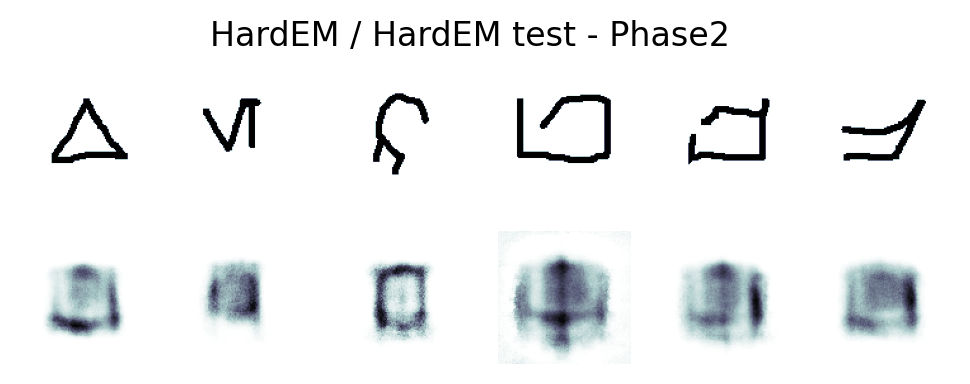

In [1204]:
fig, axs = plt.subplots(2, n_show, figsize=(6, 2))
for ax, ix_target in zip(axs.T, ixs_target):
    img_truth = X_test[ix_target].reshape(dim_width, dim_width)
    # img_reconstruct = eval_unamortised(model_test, X_test, params_encoder_hem_test, params_decoder_hem)[2][0][ix_target]
    img_reconstruct = eval_unamortised(model_test, X_test, params_encoder_hem_test, params_decoder_hem)[1][ix_target]
    ax[0].imshow(img_truth, cmap="bone")
    img_reconstruct = nn.sigmoid(img_reconstruct).reshape(dim_width, dim_width)
    ax[1].imshow(img_reconstruct, cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.suptitle("HardEM / HardEM test - Phase2")

# VAE

In [1205]:
model = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
config = hlax.amortised.CheckpointsConfig(
    num_epochs=500,
    batch_size=200,
    eval_epochs=[],
)

In [1206]:
%%time

tx_vae = optax.adam(1e-4)

output_train = hlax.amortised.train_checkpoints(
    key_train, model, config, X_warmup, elbo_bern, tx_vae
)
# checkpoint_params = output_train["checkpoint_params"]
state_vae = output_train["state_final"]
params_decoder_vae = state_vae.params["params"]["decoder"]

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 1min 10s, sys: 16.5 s, total: 1min 26s
Wall time: 3min 20s


Text(0.5, 0.98, 'VAE - Phase1')

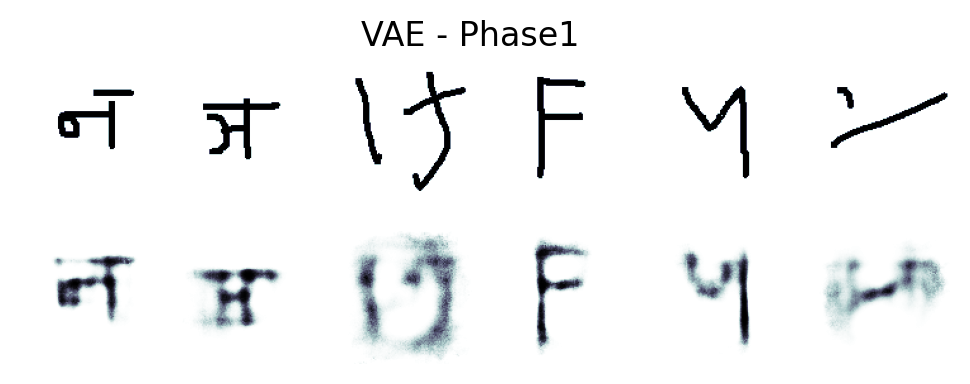

In [1207]:
fig, axs = plt.subplots(2, n_show, figsize=(6, 2))

for ax, ix_target in zip(axs.T, ixs_target):
    X_rec = model.apply(state_vae.params, X_warmup[ix_target], key)[2][0].reshape(dim_width, dim_width)
    X_rec = nn.sigmoid(X_rec)    
    X_org = X_warmup[ix_target].reshape(dim_width, dim_width)
    ax[0].imshow(X_org, cmap="bone")
    ax[1].imshow(X_rec, cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
    plt.axis("off")
plt.suptitle("VAE - Phase1")

### Test (VAE)

In [1208]:
%%time

tx_vae = optax.adam(1e-5)
model_vae = hlax.models.VAEBern(dim_latent, dim_obs[0], Encoder, Decoder)
params_test_init = model_vae.init(key_test, X_test[:2], key_test)

params_test_init = unfreeze(params_test_init)
params_test_init["params"]["decoder"] = unfreeze(params_decoder_vae)
params_test_init = freeze(params_test_init)

state_vae_test = TrainState.create(
    apply_fn=model_vae.apply,
    params=params_test_init,
    tx=tx_vae,
)

output_test = hlax.amortised.train_encoder(
    key_train, config_test, X_test, state_vae_test, elbo_bern
)
hist_loss_vae_amortised = output_test[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 2.66 s, total: 16.1 s
Wall time: 10.3 s


Text(0.5, 0.98, 'VAE train / VAE test - Phase2')

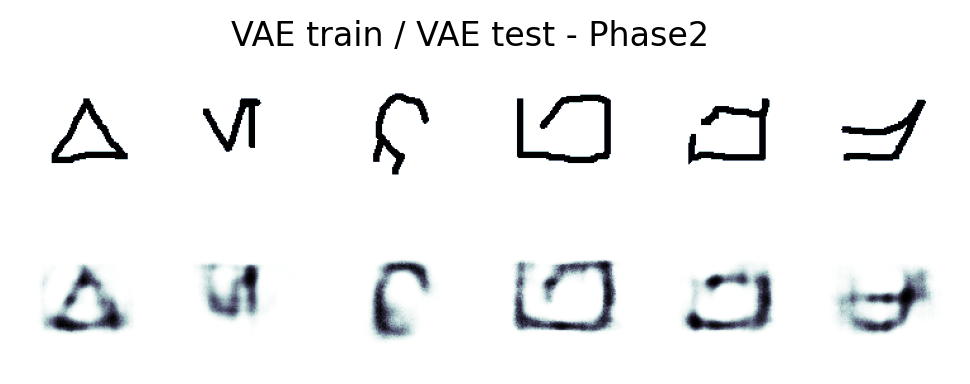

In [1209]:
fig, axs = plt.subplots(2, n_show, figsize=(6, 2))
for ax, ix_target in zip(axs.T, ixs_target):
    img_truth = X_test[ix_target].reshape(dim_width, dim_width)
    img_reconstruct = model_vae.apply(output_test[0].params, X_test[ix_target], key)[2][0].reshape(dim_width, dim_width)
    img_reconstruct = nn.sigmoid(img_reconstruct)
    
    ax[0].imshow(img_truth, cmap="bone")
    ax[1].imshow(img_reconstruct, cmap="bone")
    
    ax[0].axis("off")
    ax[1].axis("off")
plt.suptitle("VAE train / VAE test - Phase2")

### Test (Unamortised diagonal FA model)

In [1210]:
state = TrainState.create(
    apply_fn=model_test.apply,
    params=params_decoder_vae,
    tx=tx_test
)

res_vae_test = hlax.unamortised.train_encoder(key_it_test, model_test, config_test, X_test, state, part_lossfn_test, tx_test_hem)
params_encoder_vae_test = res_vae_test["state_final"].params
hist_loss_vae = res_vae_test["hist_loss"]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'VAE / HardEM test - Phase2')

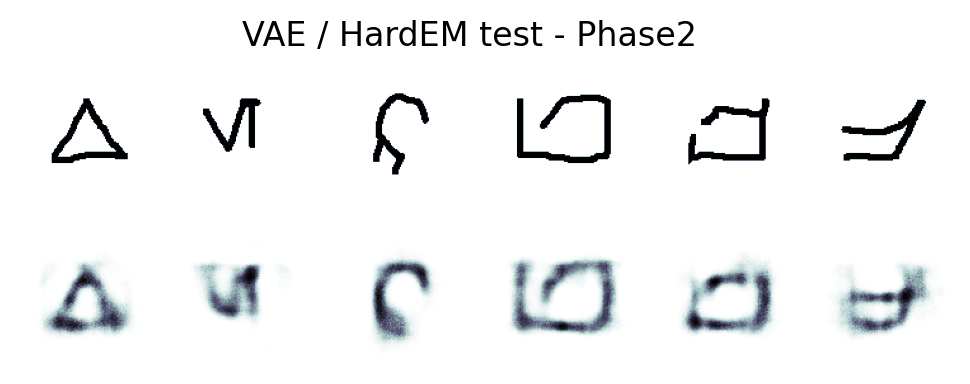

In [1211]:
fig, axs = plt.subplots(2, n_show, figsize=(6, 2))
for ax, ix_target in zip(axs.T, ixs_target):
    img_truth = X_test[ix_target].reshape(dim_width, dim_width)
    img_reconstruct = eval_unamortised(model_test, X_test, params_encoder_vae_test, params_decoder_vae)[1][ix_target]
    # img_reconstruct = eval_unamortised(model_test, X_test, params_encoder_vae_test, params_decoder_vae)[2][0][ix_target]
    ax[0].imshow(img_truth, cmap="bone")
    img_reconstruct = nn.sigmoid(img_reconstruct).reshape(dim_width, dim_width)
    ax[1].imshow(img_reconstruct, cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.suptitle("VAE / HardEM test - Phase2")

## Hist loss on test set

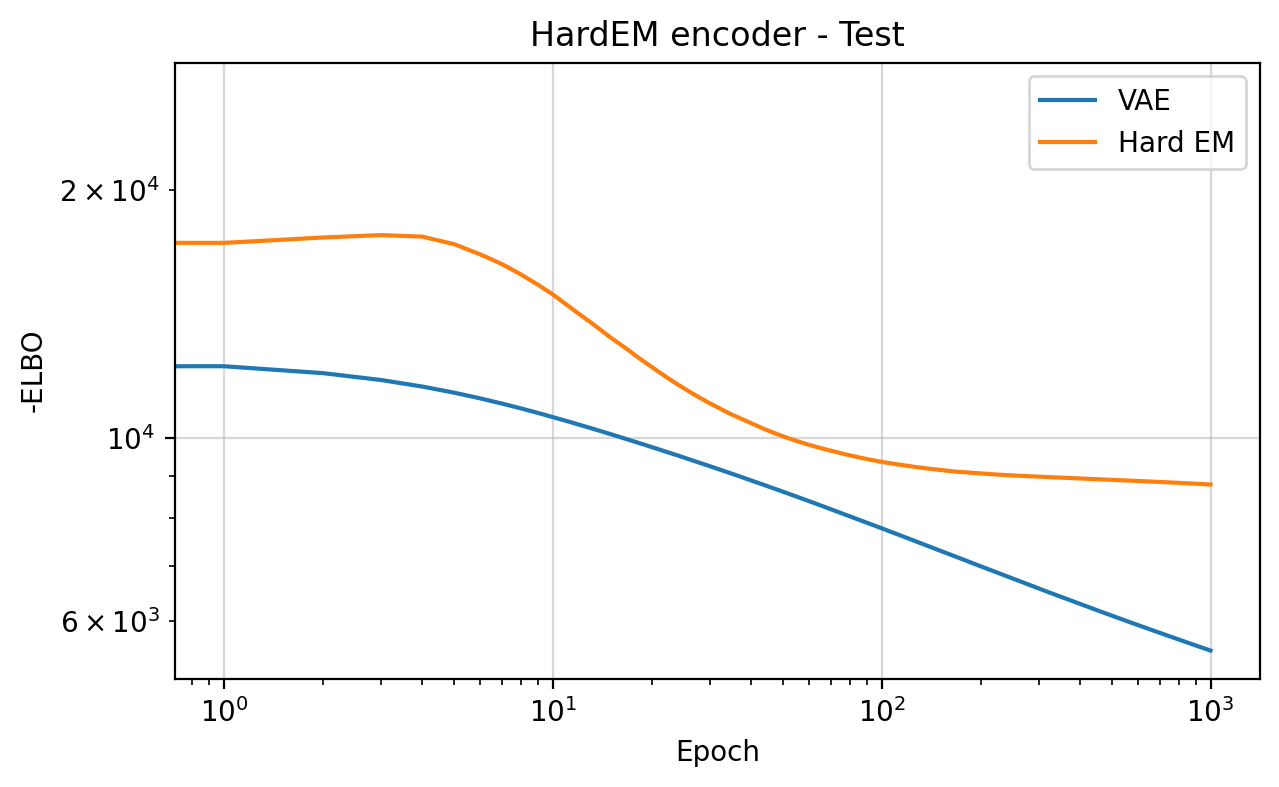

In [1212]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.title("HardEM encoder - Test")
plt.plot(hist_loss_vae, label="VAE")
plt.plot(hist_loss_hem, label="Hard EM")
plt.ylabel("-ELBO")
plt.xlabel("Epoch")
plt.yscale("log")
plt.xscale("log")
plt.grid(alpha=0.5)
plt.legend()

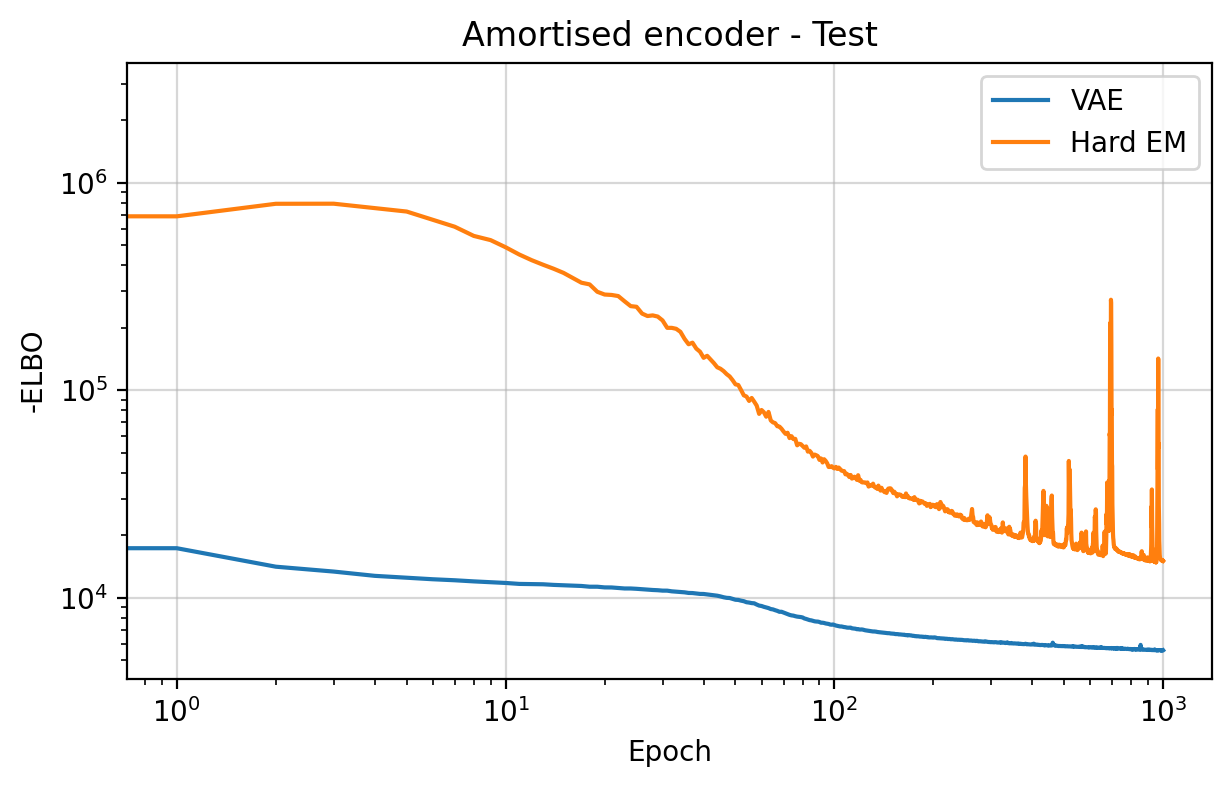

In [1213]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.title("Amortised encoder - Test")
plt.plot(hist_loss_vae_amortised, label="VAE")
plt.plot(hist_loss_hem_amortised, label="Hard EM")
plt.ylabel("-ELBO")
plt.xlabel("Epoch")
plt.xscale("log")
plt.yscale("log")
plt.grid(alpha=0.5)
plt.legend()